# Draw raster on top of base map
# Introduction

In geospatial analysis, working with satellite imagery and defining spatial extents is crucial for accurate analysis. This tutorial demonstrates how to fetch and visualize satellite imagery over a specific region, overlay it on a base map, and ensure the correct handling of coordinate transformations.

# Objective

The objective of this tutorial is to show you how to fetch satellite imagery using OpenEO and overlay it on a base map. We will demonstrate how to correctly handle coordinate transformations to ensure accurate spatial analysis.

In this notebook, you will explore the following concepts:

1. **Connecting to OpenEO**: Establish a connection to the OpenEO backend to access and manipulate satellite imagery data.
2. **Defining Spatial Extents**: Learn how to define and transform the bounding box coordinates for a region of interest.
3. **Fetching Satellite Imagery**: Use OpenEO to retrieve Sentinel-2 imagery data for the defined region and time period.
4. **Overlaying Raster Data on a Base Map**: Visualize the satellite imagery by overlaying it on a base map using Cartopy.

# Let's Begin

We'll start by importing the necessary Python modules and creating a connection to the OpenEO backend. Then, we will define our region of interest, fetch the corresponding satellite imagery, and visualize it on a map.


In [1]:
import openeo
import io
import numpy as np

from shapely.geometry import shape, Polygon

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

from pyproj import Transformer

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from config import user,passwd,eo_service_url
from demo_helpers import show_result
from demo_regions import s2
 
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
# Connect to OpenEO
conn = openeo.connect(eo_service_url)
conn.authenticate_basic(username=user, password=passwd)
#conn.authenticate_oidc()

<Connection to 'https://openeo.digitalearth.se/' with BasicBearerAuth>

## Coordinates to [Rostbollen](https://sv.wikipedia.org/wiki/The_Opposite_Sphere) in Luleå.

In [3]:
(lat, lon) = (65.61440779660053, 22.10106269154247)

In [4]:
# Create a transformer from EPSG:4326 to EPSG:3006
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3006", always_xy=True)
# Transform the polygon coordinates
x, y = transformer.transform(lon, lat)

# Create a bounding box with size half_size * 2 in meters.
half_size = 500

# Adjust bounds
east = x + half_size
west = x - half_size
north = y + half_size
south = y - half_size


In [5]:
# Define padded bounding box in correct CRS
bbox = {
    'east': east,
    'south': south,
    'west': west,
    'north': north,
    'crs':"EPSG:3006"
}
bbox

{'east': 827098.674654932,
 'south': 7294896.913037792,
 'west': 826098.674654932,
 'north': 7295896.913037792,
 'crs': 'EPSG:3006'}

In [6]:
# Download S2MSI2A data
cube = conn.load_collection(
    s2.s2_msi_l2a,
    bands=["b04","b03","b02"], #RGB channels
    spatial_extent=bbox,
    temporal_extent=["2020-06-08", "2020-06-09"],
)
cube = cube.reduce_dimension(dimension="t", reducer="first")
res = cube.download()

In [7]:
# Read the result
filelike = io.BytesIO(res)
raster_data = rasterio.open(filelike)
raster_data.read(1) 

array([[1254., 1269., 1268., ..., 2310., 2256., 1975.],
       [1264., 1261., 1260., ..., 2268., 2038., 1672.],
       [1260., 1269., 1278., ..., 2190., 1884., 1708.],
       ...,
       [1261., 1268., 1269., ..., 1416., 1403., 1411.],
       [1250., 1260., 1269., ..., 1504., 1363., 1401.],
       [1240., 1250., 1253., ..., 1811., 1634., 1628.]])

In [8]:
# Read the result
filelike = io.BytesIO(res)
raster_data = rasterio.open(filelike)

# Split the data into color channels
red = raster_data.read(1)   # Red channel
green = raster_data.read(2) # Green channel
blue = raster_data.read(3)  # Blue channel

# Determine the actual range of the data
max_value = np.max([red.max(), green.max(), blue.max()])

# Scale the data to 0-1 range based on the actual max value (needed for plt.imshow)
red_scaled = red / max_value
green_scaled = green / max_value
blue_scaled = blue / max_value

# Stack the scaled bands to form an RGB image
rgb_scaled = np.dstack((red_scaled, green_scaled, blue_scaled))

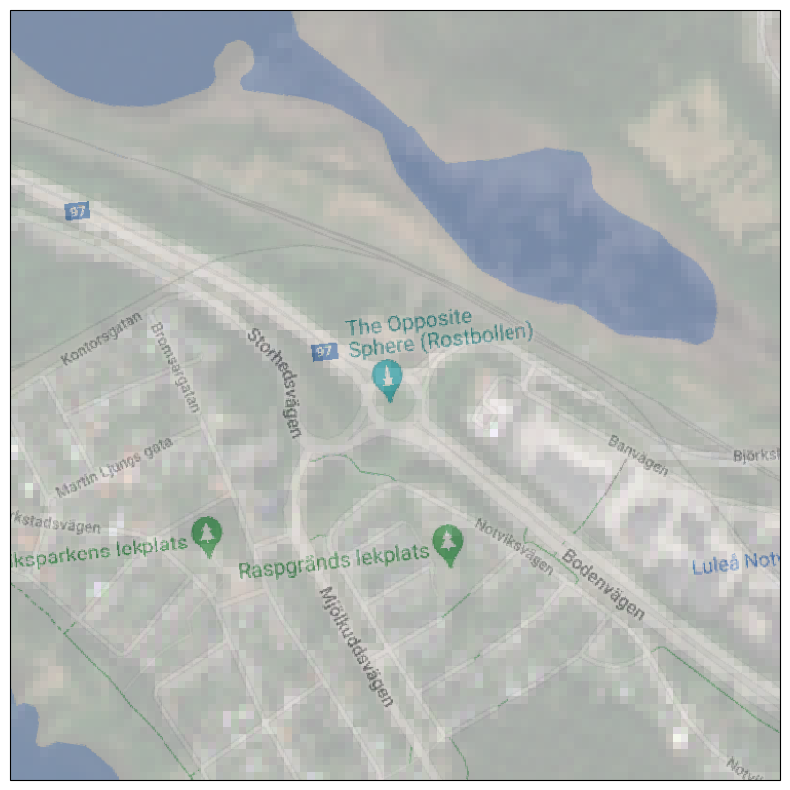

In [9]:
# Define the Coordinate Reference System (CRS)
# EPSG:3006 is used for the Swedish national coordinate system (SWEREF99 TM)
crs = 3006

# Set the extent of the map based on the bounding box coordinates
# The extent is defined as (west, east, south, north) in the CRS defined above
extent = (west, east, south, north)

# Create a Cartopy map projection using the specified CRS
ax = plt.axes(projection=ccrs.epsg(crs))

# Set the geographical extent of the map view using the bounding box defined earlier
# This ensures that the map is centered around the region of interest
ax.set_extent(extent, crs=ccrs.epsg(crs))


# Choose base map
request = cimgt.GoogleTiles()
#request = cimgt.OSM()

ax.add_image(request, 15, alpha=.5)
ax.imshow(rgb_scaled, extent=extent, transform=ccrs.epsg(crs))